### The purpose of this notebook to is to recreate the regress the SSH in GLORYS onto the CWI developed in Amaya et al. (2022)

In [3]:
import os, gc; from os.path import exists
os.chdir('/vortexfs1/home/anthony.meza/CTWPC/scripts')
main_dir = "/vortexfs1/home/anthony.meza/CTWPC"
plotsdir = lambda x="": main_dir + "/plots/" + x
GLORYS_dir = lambda x="": main_dir + "/GLORYS_data" + x
GLORYS_data_dir = lambda x="": main_dir + "/GLORYS_processed/" + x
ERA5_data_dir = lambda x="": main_dir + "/ERA5_data/" + x

In [12]:
from help_funcs import * 
# from eofs.xarray import Eof
import numpy as np
import xarray as xr
import pandas as pd
import cmocean.cm as cm
from pathlib import Path
from natsort import natsorted
import matplotlib.pyplot as plt
import gsw
import gc
import os 
from os.path import exists
from scipy import signal
import copy
from scipy.signal.windows import tukey
from scipy import linalg
from scipy.fft import fft2, ifft2, fftfreq, fftshift, fft, rfft2, irfft2, ifftshift
import seaborn as sns
sns.set_context("talk")
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [5]:
#will plot relevant locations to a line plot
normalize = lambda x: (x - np.mean(x)) / np.std(x)
def plot_geovlines(labels_dict, ax):
    ax2 = ax.twiny()
    locs=[]
    labels = []
    ylims = ax.get_ylim()
    for (key, value) in labels_dict.items():
        ax2.axvline(value, c = "black", alpha = 0.5, zorder = 9, linestyle = "--")
        locs+=[value]
        labels+=[key]
    ax2.set_xticklabels(labels)
    ax2.set_xticks(locs)
    ax2.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

### Reading in the GLORYS and ERA5 data files. Files have been preprocessed and combined in order to take advantage of the **dask** feature of xarray. We also remove their seasonal cliamtologies

In [7]:
anomalies = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies.nc"))
# anomalies_filtered = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_bandpass.nc"))
anomalies_filtered_kandf = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars_Anomalies_SpaceTimeFiltered.nc"))
hovmoller_ds = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Path.nc")).compute()
coast_vars = xr.open_dataset(GLORYS_data_dir("GLORYS_Coastal_Vars.nc")).compute()
bathy_ds = xr.open_dataset(GLORYS_data_dir("CaliforniaCoastalMask.nc"))
coords_pth = "/vortexfs1/share/cdx/hseo/Data/MERCATOR/GLO-MFC_001_030_coordinates.nc"
coords = xr.open_dataset(coords_pth).sel(latitude = slice(-2, 60), longitude = slice(-150, -75) )

In [31]:
hovmoller_ds

<xarray.Dataset>
Dimensions:   (distance: 1908, time: 10013)
Coordinates:
  * distance  (distance) float64 0.0 9.269 18.54 ... 2.203e+04 2.204e+04
  * time      (time) datetime64[ns] 1993-01-01T12:00:00 ... 2020-05-31T12:00:00
Data variables:
    lat_path  (distance) float64 6.331e-08 6.331e-08 6.331e-08 ... 59.83 59.92
    lon_path  (distance) float64 -149.9 -149.8 -149.7 ... -139.8 -139.7 -139.6
    EQ        (distance) float32 1.0 1.0 1.0 1.0 1.0 1.0 ... 0.0 0.0 0.0 0.0 0.0
    COL       (distance) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    SW        (distance) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GC_E      (distance) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GC_C      (distance) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    GC_W      (distance) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    NW        (distance) float32 0.0 0.0 0.0 0.0 0.0 0.0 ... 1.0 1.0 1.0 1.0 1.0

In [8]:
distances = hovmoller_ds.distance.values
findminlat = lambda lat, lat0: np.argmin((lat - lat0)**2)

distance_labels = {}
distance_labels["SA"] = np.max(hovmoller_ds.EQ.values * distances)
distance_labels["GC W"] = distances[hovmoller_ds.GC_C.values.astype("bool")].mean()
distance_labels["GC E"] = distances[hovmoller_ds.GC_E.values.astype("bool")].max() - (distance_labels["GC W"] - distances[hovmoller_ds.GC_C.values.astype("bool")].min())
distance_labels["LA"] = distances[findminlat(hovmoller_ds.lat_path.values, 33)]
distance_labels["SF"] = distances[findminlat(hovmoller_ds.lat_path.values, 38)]

In [23]:
xdistance_labels = {k:v -distance_labels["SA"]  for k, v in distance_labels.items()}


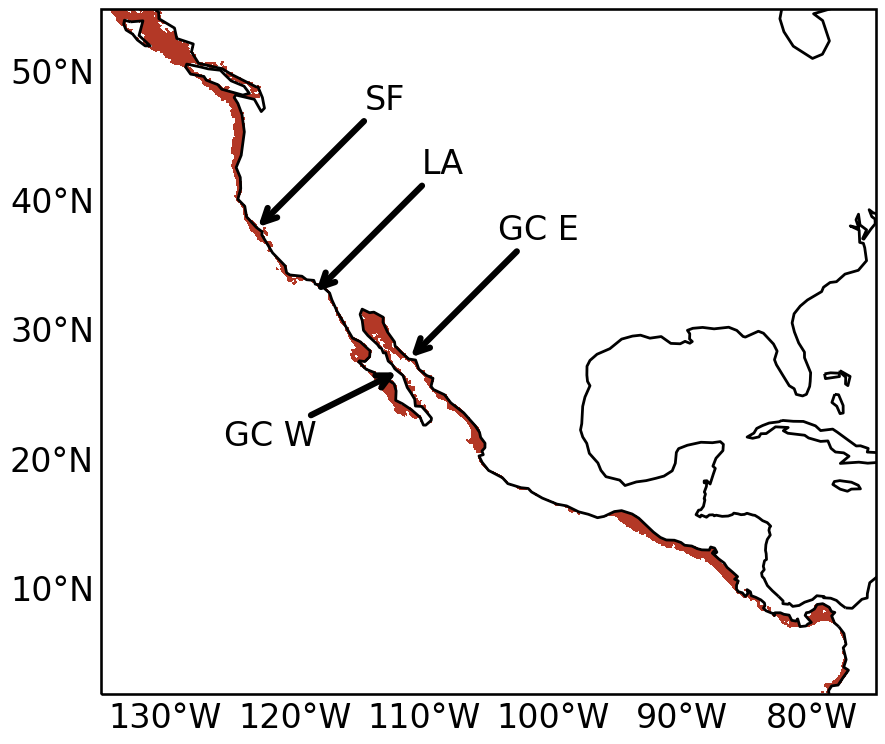

In [65]:
sns.set_context("talk")

tot_mask = bathy_ds.GC_E + bathy_ds.GC_W + bathy_ds.GC_C + bathy_ds.SW + bathy_ds.NW + bathy_ds.COL

bathy_ds.GC_E.values = bathy_ds.GC_E.values * tot_mask
bathy_ds.GC_W.values = bathy_ds.GC_W.values  * tot_mask
bathy_ds.GC_C.values = bathy_ds.GC_C.values  * tot_mask
bathy_ds.SW.values   = bathy_ds.SW.values  * tot_mask
bathy_ds.NW.values   = bathy_ds.NW.values  * tot_mask
bathy_ds.COL.values   = bathy_ds.COL.values * tot_mask
tot_mask = bathy_ds.GC_E + bathy_ds.GC_W + bathy_ds.GC_C + bathy_ds.SW + bathy_ds.NW + bathy_ds.COL
tot_mask.values[tot_mask.values == 0] = np.nan
fig, axes = plt.subplots(figsize = (10, 10), subplot_kw={'projection': ccrs.PlateCarree()})

sns.set_context("poster")
tot_mask.sel(latitude = slice(2, 55), longitude = slice(-135, None)).plot.contourf(ax = axes, cmap = cm.balance, 
                                                                            vmin = -1.75, vmax = 1.75, 
                                                            add_colorbar = False,
                                                                            transform = ccrs.PlateCarree())



gl = axes.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.0, linestyle='--')
gl.top_labels = False
gl.right_labels = False
axes.coastlines()    

for key in ["GC W", "GC E", "LA", "SF"]:
    y = hovmoller_ds.sel(distance = distance_labels[key], method = "nearest").lat_path.values
    x = hovmoller_ds.sel(distance = distance_labels[key], method = "nearest").lon_path.values
    # Plot the point
    # axes.scatter(x, y, color='black', marker='o', transform = ccrs.PlateCarree(), s = 30)
    # Draw an arrow pointing to the point
    arrow_props = dict(facecolor='black', arrowstyle='->', linewidth=4.5)
    if key == "GC W":
        axes.annotate(key, xy=(x, y), xytext=(x-10, y-5), 
                    ha='center', va='center', arrowprops=arrow_props, transform = ccrs.PlateCarree())
    else:
        axes.annotate(key, xy=(x, y), xytext=(x+10, y+10), 
                    ha='center', va='center', arrowprops=arrow_props, transform = ccrs.PlateCarree())
fig.savefig(plotsdir("generals/CoastalMask.png"), bbox_inches = "tight")

/tmp/ipykernel_379653/1323804986.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


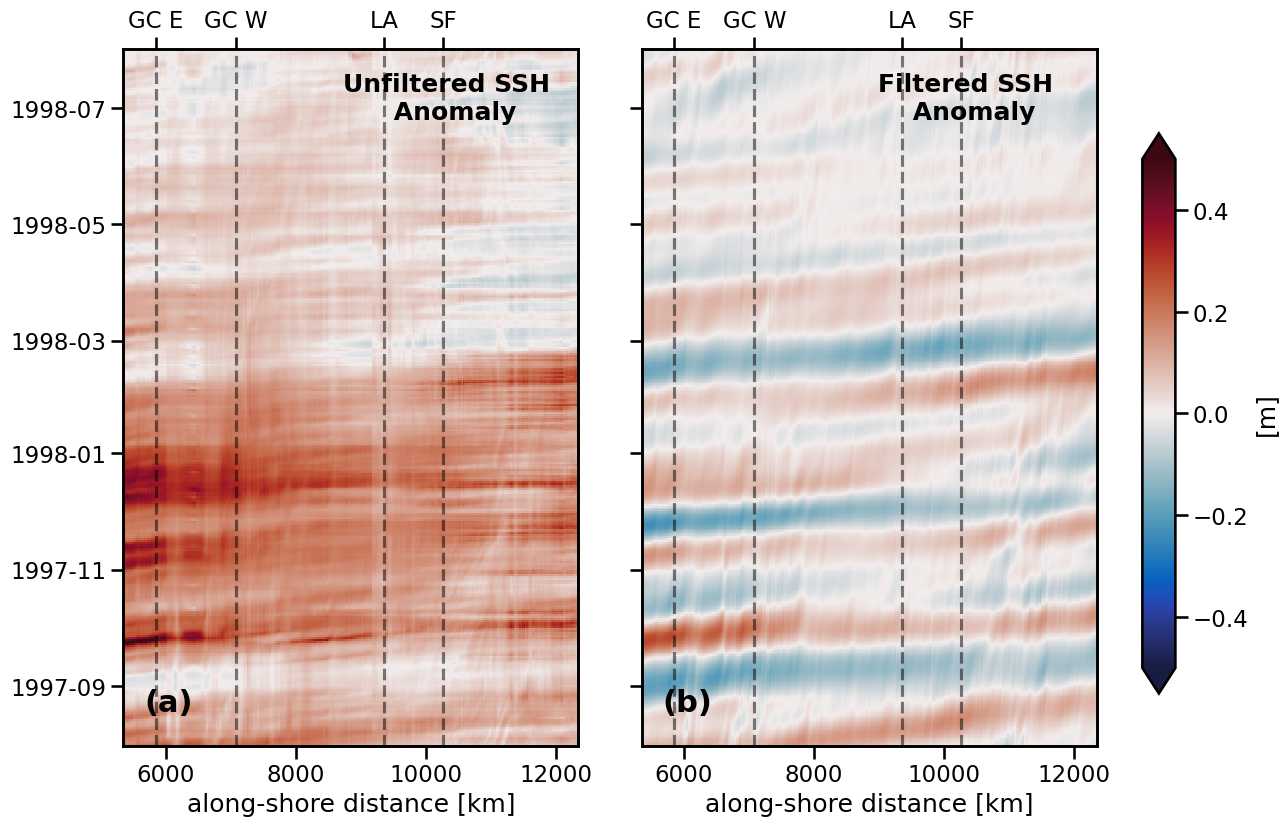

In [67]:
sns.set_context("talk")

CA_SSH = anomalies_filtered_kandf.zos.sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SSH = CA_SSH.sel(time = slice("1997.8", "1998.7"))
CA_SST = anomalies_filtered_kandf.thetao.sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SST = CA_SST.sel(time = slice("1997.8", "1998.7"))
CA_SSH["distance"] = CA_SSH["distance"] - distance_labels["SA"]
CA_SST["distance"] = CA_SST["distance"] - distance_labels["SA"]

CA_SSH_unfilt = anomalies.zos.sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SSH_unfilt = CA_SSH_unfilt.sel(time = slice("1997.8", "1998.7"))
CA_SST_unfilt = anomalies.thetao.isel(depth = 0).sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SST_unfilt = CA_SST_unfilt.sel(time = slice("1997.8", "1998.7"))

CA_SSH_unfilt["distance"] = CA_SSH_unfilt["distance"] - distance_labels["SA"]
CA_SST_unfilt["distance"] = CA_SST_unfilt["distance"] - distance_labels["SA"]

fig, ax = plt.subplots(1, 2, figsize = (11,8), sharey = True )

fig.tight_layout()
[a.set_ylabel("") for a in ax.flatten()]
[a.set_xlabel("along-shore distance [km]") for a in ax.flatten()]

[a.set_title("") for a in ax.flatten()]
cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7])

CA_SSH_unfilt.plot(ax = ax[0], vmin = -0.5, vmax = 0.5, cmap = cm.balance, extend = "both", add_labels = False, add_colorbar = False)
CA_SSH.plot(ax = ax[1], vmin = -0.5, vmax = 0.5, cmap = cm.balance, extend = "both", cbar_ax = cbaxes, add_labels = False, 
                                                                                               cbar_kwargs = {"label":"[m]", "extend": "both", "location":"right", 
                                                                                                              "orientation":"vertical",
                                                                                                             "fraction":0.02, "pad":0.05})

[plot_geovlines(xdistance_labels, a) for a in ax.flatten()]


dx = (CA_SSH.distance[-1] - CA_SSH.distance[0]) * 1e3
ax[0].text(0.72, 0.9, "Unfiltered SSH \n Anomaly", transform=ax[0].transAxes, horizontalalignment = "center", fontweight = "bold", zorder = 10)
ax[1].text(0.72, 0.9, "Filtered SSH \n Anomaly", transform=ax[1].transAxes, horizontalalignment = "center", fontweight = "bold")
ax[0].text(0.1, 0.05, "(a)", transform=ax[0].transAxes, fontsize = 22, horizontalalignment = "center", fontweight = "bold", zorder = 10)
ax[1].text(0.1, 0.05, "(b)", transform=ax[1].transAxes, fontsize = 22, horizontalalignment = "center", fontweight = "bold", zorder = 10)

# print("approximate wave speed is: ", dx.data/ dt, " m/s")
fig.savefig(plotsdir("generals/SSH_Hovmoller98.png"), bbox_inches = "tight", dpi = 400)

/tmp/ipykernel_379653/1323804986.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax2.set_xticklabels(labels)


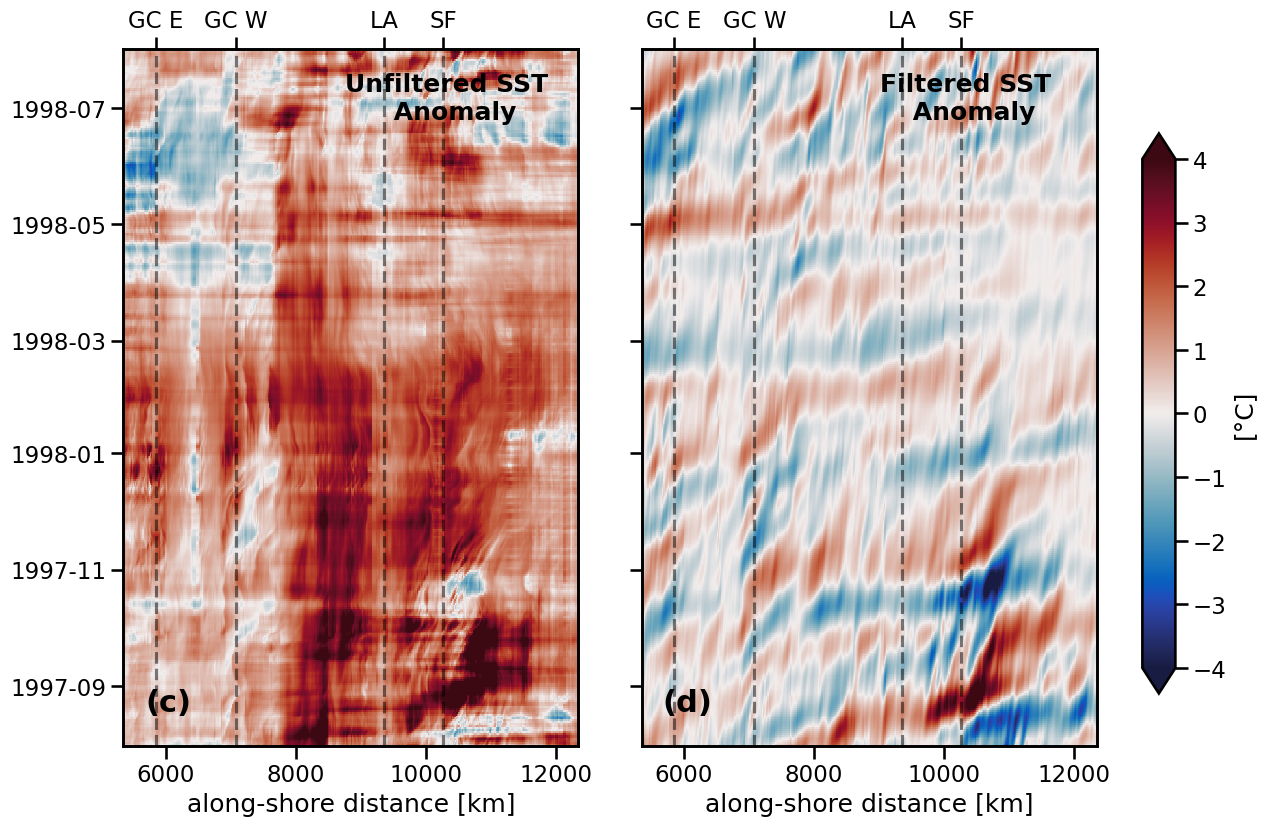

In [70]:
sns.set_context("talk")

CA_SSH = anomalies_filtered_kandf.zos.sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SSH = CA_SSH.sel(time = slice("1997.8", "1998.7"))
CA_SST = anomalies_filtered_kandf.thetao.sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SST = CA_SST.sel(time = slice("1997.8", "1998.7"))
CA_SSH["distance"] = CA_SSH["distance"] - distance_labels["SA"]
CA_SST["distance"] = CA_SST["distance"] - distance_labels["SA"]

CA_SSH_unfilt = anomalies.zos.sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SSH_unfilt = CA_SSH_unfilt.sel(time = slice("1997.8", "1998.7"))
CA_SST_unfilt = anomalies.thetao.isel(depth = 0).sel(distance = slice(distance_labels["LA"] - 4000, distance_labels["LA"] + 3000))
CA_SST_unfilt = CA_SST_unfilt.sel(time = slice("1997.8", "1998.7"))
CA_SSH_unfilt["distance"] = CA_SSH_unfilt["distance"] - distance_labels["SA"]
CA_SST_unfilt["distance"] = CA_SST_unfilt["distance"] - distance_labels["SA"]

fig, ax = plt.subplots(1, 2, figsize = (11, 8), sharey = True )

fig.tight_layout()
[a.set_ylabel("") for a in ax.flatten()]
[a.set_xlabel("along-shore distance [km]") for a in ax.flatten()]

[a.set_title("") for a in ax.flatten()]
cbaxes = fig.add_axes([1, 0.15, 0.03, 0.7])

CA_SST_unfilt.plot(ax = ax[0], vmin = -4, vmax = 4, cmap = cm.balance, extend = "both", add_labels = False, add_colorbar = False)
CA_SST.plot(ax = ax[1], vmin = -4, vmax = 4, cmap = cm.balance, extend = "both", cbar_ax = cbaxes, add_labels = False, 
                                                                                               cbar_kwargs = {"label":"[°C]", "extend": "both", "location":"right", 
                                                                                                              "orientation":"vertical",
                                                                                                             "fraction":0.02, "pad":0.05})


[plot_geovlines(xdistance_labels, a) for a in ax.flatten()]

ax[0].text(0.72, 0.9, "Unfiltered SST \n Anomaly", transform=ax[0].transAxes, horizontalalignment = "center", fontweight = "bold", zorder = 10)
ax[1].text(0.72, 0.9, "Filtered SST \n Anomaly", transform=ax[1].transAxes, horizontalalignment = "center", fontweight = "bold", zorder = 10)
ax[0].text(0.1, 0.05, "(c)", transform=ax[0].transAxes, fontsize = 22, horizontalalignment = "center", fontweight = "bold", zorder = 10)
ax[1].text(0.1, 0.05, "(d)", transform=ax[1].transAxes, fontsize = 22, horizontalalignment = "center", fontweight = "bold", zorder = 10)

# print("approximate wave speed is: ", dx.data/ dt, " m/s")
fig.savefig(plotsdir("generals/SST_Hovmoller98.png"), bbox_inches = "tight", dpi = 400)